## Pruning v/s Quantization in CNNs v/s ViT

Sakshi Mahadik

Jaiwin Shah

Surya Sukumar

### Import libraries + Load dataset

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.quantization
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import timm
import copy
import os
import tempfile
from torch.ao.quantization import get_default_qconfig, prepare, convert
from torch.ao.quantization.observer import MinMaxObserver, PerChannelMinMaxObserver
from torch.ao.quantization.qconfig import QConfig

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

/home/smahadi/.local/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
/home/smahadi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")

print("Path to dataset files:", path)

100%|██████████| 60.3M/60.3M [00:00<00:00, 93.2MB/s]

Extracting files...


Path to dataset files: /home/smahadi/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [2]:
# Dataset loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = ImageFolder('fer2013/versions/1/train', transform=transform)
val_size = int(0.2 * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
test_dataset = ImageFolder('fer2013/versions/1/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check distribution
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 22968
Validation samples: 5741
Test samples: 7178


### Load Resnet18 model

In [4]:
from torchvision.models.quantization import resnet18 as resnet18_model

resnet18 = resnet18_model(pretrained=True, quantize=False)
resnet18.fc = nn.Linear(512, 7)
resnet18.eval()
resnet18.to(device)

/home/smahadi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/smahadi/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/smahadi/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s] 


QuantizableResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (add_relu): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): QuantizableBasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, e

### Pruning and Quantization methods

In [4]:
# Unstructured Pruning for CNN
def unstructured_prune_cnn(model, amount=0.3):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")
    return model

# Structured Pruning for CNN
def structured_prune_cnn(model, amount=0.5):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.ln_structured(module, name="weight", amount=amount, n=2, dim=0)
            prune.remove(module, "weight")
    return model

In [5]:
# Unstructured Pruning for ViT
def unstructured_prune_vit(model, amount=0.3):
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=amount)
            prune.remove(module, "weight")
    return model

# Structured Attention Head Pruning for ViT
def prune_vit_attention_heads(model, heads_to_prune=2):
    for name, module in model.named_modules():
        if hasattr(module, 'qkv') and hasattr(module, 'num_heads'):
            heads_dim = module.qkv.weight.shape[0] // 3
            head_size = heads_dim // module.num_heads
            qkv_weights = module.qkv.weight.data.view(3, module.num_heads, head_size, -1)
            norms = qkv_weights.norm(dim=(2, 3))
            importance = norms.sum(dim=0)
            prune_indices = torch.topk(importance, heads_to_prune, largest=False).indices
            for i in prune_indices:
                qkv_weights[:, i, :, :] = 0
            module.qkv.weight.data = qkv_weights.view(-1, module.qkv.weight.shape[1])
    return model

In [6]:
def fuse_model_blocks(model):
    torch.quantization.fuse_modules(model, [["conv1", "bn1", "relu"]], inplace=True)
    for module_name, module in model.named_children():
        if "layer" in module_name:
            for block in module:
                torch.quantization.fuse_modules(
                    block, [["conv1", "bn1", "relu"], ["conv2", "bn2"]],
                    inplace=True
                )
                if hasattr(block, "downsample") and isinstance(block.downsample, torch.nn.Sequential):
                    if len(block.downsample) >= 2:
                        torch.quantization.fuse_modules(block.downsample, ["0", "1"], inplace=True)

In [7]:
def quantize_trained_pruned_model(model, calibration_loader, num_batches=10):
    import copy
    model = copy.deepcopy(model)
    model.cpu().eval()

    # Fuse layers (must happen after pruning and training)
    fuse_model_blocks(model)

    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    torch.quantization.prepare(model, inplace=True)

    with torch.no_grad():
        for i, (x, _) in enumerate(calibration_loader):
            x = x.to(torch.float32)
            #x = x * 0.5 + 0.5  # Undo normalization: [0, 1]
            #x = torch.clamp(x, 0.0, 1.0)
            x.to("cpu")
            model(x)
            if i >= num_batches:
                break

    torch.quantization.convert(model, inplace=True)
    return model

In [8]:
def quantize_model(model, calibration_loader, num_batches=10):
    import copy
    model = copy.deepcopy(model)
    model.eval()
    model.cpu()

    # Fuse layers
    fuse_model_blocks(model)

    # Set quantization config and prepare
    model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    torch.quantization.prepare(model, inplace=True)

    # Calibration loop
    with torch.no_grad():
        for i, (x, _) in enumerate(calibration_loader):
            x = x.to(torch.float32)
            #x = x * 0.5 + 0.5  # Undo Normalize([0.5], [0.5])
            #x = torch.clamp(x, 0.0, 1.0)  # Ensure values in [0, 1]
            x.to("cpu")
            model(x)
            if i >= num_batches:
                break

    # Convert to quantized model
    torch.quantization.convert(model, inplace=True)
    return model

### Training and Evaluation methods

In [9]:
import time

def train(model, train_loader, val_loader, epochs=10, lr=1e-4):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                outputs = model(x)
                loss = criterion(outputs, y)
                val_loss += loss.item()
                correct += (outputs.argmax(1) == y).sum().item()
                total += y.size(0)

        train_loss = running_loss / len(train_loader)
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.2f}%")

In [10]:
def evaluate(model, test_loader, quantization=False):
    model.eval()

    if quantization:
        model = model.to("cpu")  # Quantized models must be on CPU
    else:
        model = model.to("cuda")

    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            if quantization:
                x, y = x.to("cpu"), y.to("cpu")
            else:
                x, y = x.to("cuda"), y.to("cuda")

            outputs = model(x)
            pred = outputs.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy = {accuracy:.2f}%")
    return accuracy

In [11]:
def measure_inference_speed(model, test_loader, quantization=False):
    model.eval()
    
    if quantization:
        device = "cpu"
        
    else:
        device = torch.device("cuda")
    
    model.to(device)
    
    start = time.time()
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            _ = model(x)
    end = time.time()
    latency = (end - start) / len(test_loader)
    print(f"Avg Inference Time per Batch: {latency:.4f} sec")
    return latency

def model_size_mb(model, use_state_dict=True):
    with tempfile.NamedTemporaryFile(delete=False) as f:
        if use_state_dict:
            torch.save(model.state_dict(), f.name)
        else:
            torch.save(model, f.name)
        size_mb = os.path.getsize(f.name) / (1024 * 1024)
    print(f"Model Size ({'state_dict' if use_state_dict else 'full model'}): {size_mb:.2f} MB")
    return size_mb

### Plot methods

#### Accuracy v/s Pruning amount

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for polished look
sns.set(style="whitegrid", context="notebook")

def plot_validation_and_test_accuracy(pruning_amounts, val_accuracies, test_accuracies, pruning_type='structured'):
    """
    Plots validation and test accuracy vs. pruning amount for a specific pruning type.

    Args:
        pruning_amounts (list of float): Amounts of pruning applied (e.g., [0.0, 0.3, 0.5]).
        val_accuracies (list of float): Validation accuracies in percent.
        test_accuracies (list of float): Test accuracies in percent.
        pruning_type (str): 'structured' or 'unstructured' (used in plot title and legend).
    """
    plt.figure(figsize=(8, 5))

    plt.plot(pruning_amounts, val_accuracies, marker='o', label='Validation Accuracy', color='blue', linewidth=2)
    plt.plot(pruning_amounts, test_accuracies, marker='s', label='Test Accuracy', color='green', linewidth=2)

    # Annotate values
    for x, y in zip(pruning_amounts, val_accuracies):
        plt.text(x, y + 0.5, f"{y:.2f}%", ha='center', fontsize=9, color='blue')

    for x, y in zip(pruning_amounts, test_accuracies):
        plt.text(x, y - 1.5, f"{y:.2f}%", ha='center', fontsize=9, color='green')

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title(f"{pruning_type.capitalize()} Pruning: Accuracy vs. Pruning Amount", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(pruning_amounts)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="notebook")

def plot_accuracy_vs_pruning_grouped(pruning_type, pruning_amount, val_accuracies, test_accuracies):
    """
    Plots validation and test accuracy vs. pruning amount for multiple pruning types
    (e.g., 'baseline', 'structured', 'unstructured') on the same plot.

    Args:
        pruning_type (list of str): Type for each model ('baseline', 'structured', etc.)
        pruning_amount (list of float): Corresponding pruning amount (e.g., [0.0, 0.3, 0.5])
        val_accuracies (list of float): Corresponding validation accuracy in %
        test_accuracies (list of float): Corresponding test accuracy in %
    """
    plt.figure(figsize=(9, 5))

    unique_types = sorted(set(pruning_type))
    for ptype in unique_types:
        xs = [amt for t, amt in zip(pruning_type, pruning_amount) if t == ptype]
        #val_ys = [v for t, v in zip(pruning_type, val_accuracies) if t == ptype]
        test_ys = [v for t, v in zip(pruning_type, test_accuracies) if t == ptype]

        #plt.plot(xs, val_ys, marker='o', linestyle='-', linewidth=2, label=f'{ptype} - Val')
        plt.plot(xs, test_ys, marker='s', linestyle='-', linewidth=2, label=f'{ptype}')

        # Annotate points
        #for x, y in zip(xs, val_ys):
        #    plt.text(x, y + 0.5, f"{y:.1f}%", ha='center', fontsize=9)
        
        for x, y in zip(xs, test_ys):
            plt.text(x, y - 1.2, f"{y:.1f}%", ha='center', fontsize=9)

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.title("Accuracy vs. Pruning", fontsize=14)
    plt.legend(title="Model Type")
    plt.xticks(sorted(set(pruning_amount)))
    plt.ylim(50, 100)
    plt.tight_layout()
    plt.show()

#### Flops after pruning

In [14]:
from ptflops import get_model_complexity_info

# FLOPs calculation helper
def get_flops(model, input_res=(3, 224, 224)):
    model.eval()
    macs, params = get_model_complexity_info(model, input_res, as_strings=False,
                                              print_per_layer_stat=False, verbose=False)
    flops = 2 * macs  # Approximate FLOPs: 1 MAC = 2 FLOPs
    return flops / 1e9  # Convert to GFLOPs

In [15]:
# Count total and non-zero parameters (Conv + Linear)
def compute_sparsity(model):
    total_weights = 0
    nonzero_weights = 0

    for module in model.modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if hasattr(module, 'weight'):
                total_weights += module.weight.nelement()
                nonzero_weights += torch.count_nonzero(module.weight)

    sparsity = 1 - (nonzero_weights / total_weights)
    return sparsity.item()

In [16]:
def plot_flops_after_pruning(labels, flops_values):
    plt.figure(figsize=(7, 4))
    bars = plt.bar(labels, flops_values, color=['steelblue', 'green', 'orange'])
    plt.title('Estimated Effective FLOPs After Pruning')
    plt.ylabel('FLOPs (GigaFLOPs)')
    plt.ylim(0, max(flops_values) * 1.2)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height * 1.01, f'{height:.2f}', ha='center')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Inference time accross pruning models

In [40]:
def plot_inference_vs_pruning(pruning_type, pruning_amount, inference_times):
    plt.figure(figsize=(8, 6))
    for ptype in set(pruning_type):
        xs = [amt for t, amt in zip(pruning_type, pruning_amount) if t == ptype]
        ys = [t for t_, t in zip(pruning_type, inference_times) if t_ == ptype]
        plt.plot(xs, ys, marker='o', label=ptype, linewidth=2)

        for x, y in zip(xs, ys):
            plt.text(x, y + 0.0005, f"{y:.4f}s", ha='center', fontsize=9)

    plt.xlabel("Pruning Amount", fontsize=12)
    plt.ylabel("Inference Time (s/batch)", fontsize=12)
    plt.title("Inference Time vs. Pruning", fontsize=14)
    plt.legend(title="Model Type")
    plt.xticks([0.0, 0.5])
    plt.tight_layout()
    plt.show()

#### Parameter Count across models

In [51]:
import matplotlib.pyplot as plt

def plot_parameter_counts(model_labels, param_counts_millions, title="Parameter Count Across Models"):
    """
    Plots parameter count (in millions) for different models.

    Args:
        model_labels (List[str]): Labels for each model (e.g., ['Baseline', 'Struct-0.3', 'Quantized', ...])
        param_counts_millions (List[float]): Corresponding parameter counts in millions
        title (str): Plot title
    """
    plt.figure(figsize=(10, 5))
    bars = plt.bar(model_labels, param_counts_millions, color='skyblue')

    # Annotate bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.2, f"{height:.2f}M", ha='center', fontsize=10)

    plt.ylabel("Parameter Count (Millions)", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(rotation=30, ha='right')
    plt.ylim(0, max(param_counts_millions) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [58]:
def get_parameter_count(model):
    """
    Returns non-zero parameter count (in millions) for any model,
    including quantized ones with packed weights.
    """
    nonzero = 0

    for module in model.modules():
        # Case 1: FP32 or pruned model
        if hasattr(module, "weight") and isinstance(module.weight, torch.Tensor):
            nonzero += torch.count_nonzero(module.weight).item()

        # Case 2: Quantized model (Conv2d, Linear, etc.)
        elif hasattr(module, "_packed_params") and hasattr(module._packed_params, "_weight_bias"):
            try:
                qweight, _ = module._packed_params._weight_bias()
                nonzero += torch.count_nonzero(qweight.dequantize()).item()
            except Exception:
                continue  # fallback silently

    return nonzero / 1e6  # millions


#### Accuracy v/s Preciison level

In [18]:
def plot_accuracy_vs_precision(precisions, accuracies):
    """
    Plot model accuracy vs. precision level.
    
    Args:
        precisions (List[str]): Precision levels (e.g., ['FP32', 'INT8'])
        accuracies (List[float]): Corresponding accuracies (%)
    """
    plt.figure(figsize=(15, 4))
    plt.plot(precisions, accuracies, marker='o', linewidth=2)
    plt.title("Accuracy vs. Precision Level")
    plt.xlabel("Precision")
    plt.ylabel("Accuracy (%)")
    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.5, f"{acc:.2f}%", ha='center')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Inference time accross quantized models

In [19]:
import matplotlib.pyplot as plt

def plot_inference_time(models, times_ms):
    """
    Plot inference time for different models.
    
    Args:
        models (List[str]): Model labels (e.g., ['FP32', 'INT8', 'INT8+Pruned'])
        times_ms (List[float]): Inference times in milliseconds
    """
    plt.figure(figsize=(15, 4))
    plt.plot(models, times_ms, marker='o', linestyle='-', linewidth=2, color='red')
    plt.title("Inference Time Across Models")
    plt.xlabel("Model Type")
    plt.ylabel("Time (ms)")
    for i, t in enumerate(times_ms):
        plt.text(i, t + 0.1, f"{t:.1f} ms", ha='center')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

#### Weight Distribution

In [20]:
import numpy as np

def extract_quantized_weights(model):
    """
    Extract quantized weights (int8) from a quantized model using _packed_params.
    Returns a list of flattened numpy arrays.
    """
    weights = []
    for module in model.modules():
        if isinstance(module, (torch.nn.quantized.Conv2d, torch.nn.quantized.Linear)):
            try:
                qweight, _ = module._packed_params._weight_bias()
                weights.append(qweight.dequantize().cpu().flatten().numpy())
            except Exception as e:
                #print(f"Skipping {module}: {e}")
                pass
    return np.concatenate(weights) if weights else None

def plot_quantized_weight_distribution(model_fp32, model_int8, model_int8_pr_st, model_int8_pr_unst):
    import matplotlib.pyplot as plt
    import numpy as np

    def extract_weights(model):
        weights = []
        for module in model.modules():
            if hasattr(module, "weight") and isinstance(module.weight, torch.Tensor):
                weights.append(module.weight.detach().cpu().flatten().numpy())
        return np.concatenate(weights) if weights else None

    w_fp32 = extract_weights(model_fp32)
    w_int8 = extract_quantized_weights(model_int8)
    w_int8_st = extract_quantized_weights(model_int8_pr_st)
    w_int8_unst = extract_quantized_weights(model_int8_pr_unst)

    if w_fp32 is None and w_int8 is None and w_int8_unst and w_int8_st:
        print("No weights found.")
        return

    plt.figure(figsize=(10, 4))
    if w_fp32 is not None:
        plt.subplot(1, 2, 1)
        plt.hist(w_fp32, bins=100, color='blue', alpha=0.7)
        plt.title("Weight Distribution (FP32)")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")

    if w_int8 is not None:
        plt.subplot(1, 2, 2)
        plt.hist(w_int8, bins=100, color='orange', alpha=0.7)
        plt.title("Weight Distribution (INT8)")
        plt.xlabel("Weight Value")
        
    plt.figure(figsize=(10, 6))
    if w_int8_st is not None:
        plt.subplot(2, 2, 1)
        plt.hist(w_int8_st, bins=100, color='green', alpha=0.7)
        plt.title("Weight Distribution (INT8 + Structured pruning)")
        plt.xlabel("Weight Value")
        plt.ylabel("Frequency")
        
    if w_int8_unst is not None:
        plt.subplot(2, 2, 2)
        plt.hist(w_int8_unst, bins=100, color='red', alpha=0.7)
        plt.title("Weight Distribution (INT8 + Unstructured pruning)")
        plt.xlabel("Weight Value")

    plt.tight_layout()
    plt.show()

### Training

#### Training Baseline model

In [24]:
# === Train baseline ===
print("=== Train baseline ===")
train(resnet18, train_loader, val_loader, epochs=30)
evaluate(resnet18, test_loader)
model_size_mb(resnet18)
measure_inference_speed(resnet18, test_loader)
torch.save(resnet18, 'resnet18_models/resnet18.pt')

=== Train baseline ===
Epoch 1: Train Loss = 1.1673, Val Loss = 0.9764, Val Acc = 64.20%
Epoch 2: Train Loss = 0.7662, Val Loss = 1.0061, Val Acc = 63.73%
Epoch 3: Train Loss = 0.4149, Val Loss = 1.0956, Val Acc = 64.27%
Epoch 4: Train Loss = 0.1493, Val Loss = 1.2958, Val Acc = 64.68%
Epoch 5: Train Loss = 0.0697, Val Loss = 1.3915, Val Acc = 64.76%
Epoch 6: Train Loss = 0.0392, Val Loss = 1.4326, Val Acc = 65.01%
Epoch 7: Train Loss = 0.0286, Val Loss = 1.5157, Val Acc = 65.22%
Epoch 8: Train Loss = 0.0347, Val Loss = 1.6720, Val Acc = 63.28%
Epoch 9: Train Loss = 0.1801, Val Loss = 1.9407, Val Acc = 60.69%
Epoch 10: Train Loss = 0.0783, Val Loss = 1.6806, Val Acc = 64.33%
Epoch 11: Train Loss = 0.0292, Val Loss = 1.6378, Val Acc = 64.88%
Epoch 12: Train Loss = 0.0129, Val Loss = 1.7114, Val Acc = 65.62%
Epoch 13: Train Loss = 0.0106, Val Loss = 1.7041, Val Acc = 65.63%
Epoch 14: Train Loss = 0.0078, Val Loss = 1.7012, Val Acc = 65.49%
Epoch 15: Train Loss = 0.0056, Val Loss = 1.7355

#### Pruning baseline model + Training (Structured)

In [21]:
# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_01 = structured_prune_cnn(resnet18, amount=0.1)
train(resnet18_pruned_st_01, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_01, test_loader)
model_size_mb(resnet18_pruned_st_01)
measure_inference_speed(resnet18_pruned_st_01, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_02 = structured_prune_cnn(resnet18, amount=0.2)
train(resnet18_pruned_st_02, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_02, test_loader)
model_size_mb(resnet18_pruned_st_02)
measure_inference_speed(resnet18_pruned_st_02, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_03 = structured_prune_cnn(resnet18, amount=0.3)
train(resnet18_pruned_st_03, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_03, test_loader)
model_size_mb(resnet18_pruned_st_03)
measure_inference_speed(resnet18_pruned_st_03, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_04 = structured_prune_cnn(resnet18, amount=0.4)
train(resnet18_pruned_st_04, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_04, test_loader)
model_size_mb(resnet18_pruned_st_04)
measure_inference_speed(resnet18_pruned_st_04, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply structured pruning, then fine-tune ===")
resnet18_pruned_st_05 = structured_prune_cnn(resnet18, amount=0.5)
train(resnet18_pruned_st_05, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_st_05, test_loader)
model_size_mb(resnet18_pruned_st_05)
measure_inference_speed(resnet18_pruned_st_05, test_loader)

=== Apply structured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.3601, Val Loss = 0.3144, Val Acc = 92.67%
Epoch 2: Train Loss = 0.1494, Val Loss = 0.3063, Val Acc = 92.70%
Epoch 3: Train Loss = 0.0628, Val Loss = 0.3239, Val Acc = 92.37%
Epoch 4: Train Loss = 0.0279, Val Loss = 0.3350, Val Acc = 92.65%
Epoch 5: Train Loss = 0.0169, Val Loss = 0.3398, Val Acc = 92.56%
Test Accuracy = 65.56%
Model Size (state_dict): 42.73 MB
Avg Inference Time per Batch: 0.1200 sec
=== Apply structured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.4662, Val Loss = 0.3526, Val Acc = 89.78%
Epoch 2: Train Loss = 0.1751, Val Loss = 0.3672, Val Acc = 89.93%
Epoch 3: Train Loss = 0.0729, Val Loss = 0.3827, Val Acc = 89.83%
Epoch 4: Train Loss = 0.0311, Val Loss = 0.3824, Val Acc = 90.44%
Epoch 5: Train Loss = 0.0197, Val Loss = 0.3970, Val Acc = 90.35%
Test Accuracy = 64.80%
Model Size (state_dict): 42.73 MB
Avg Inference Time per Batch: 0.1222 sec
=== Apply structured pruning, then fine-tune =

0.11795846339875618

In [22]:
torch.save(resnet18_pruned_st_01, 'resnet18_pruned_st/resnet18_pruned_st_01.pt')
torch.save(resnet18_pruned_st_02, 'resnet18_pruned_st/resnet18_pruned_st_02.pt')
torch.save(resnet18_pruned_st_03, 'resnet18_pruned_st/resnet18_pruned_st_03.pt')
torch.save(resnet18_pruned_st_04, 'resnet18_pruned_st/resnet18_pruned_st_04.pt')
torch.save(resnet18_pruned_st_05, 'resnet18_pruned_st/resnet18_pruned_st_05.pt')

In [23]:
val_accuracies_st = []
"""val_acc = evaluate(resnet18_pruned_st_01, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_02, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_03, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_04, val_loader, quantization=False)
val_accuracies_st.append(val_acc)
val_acc = evaluate(resnet18_pruned_st_05, val_loader, quantization=False)
val_accuracies_st.append(val_acc)"""

test_accuracies_st = []
test_acc = evaluate(resnet18_pruned_st_01, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(resnet18_pruned_st_02, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(resnet18_pruned_st_03, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(resnet18_pruned_st_04, test_loader, quantization=False)
test_accuracies_st.append(test_acc)
test_acc = evaluate(resnet18_pruned_st_05, test_loader, quantization=False)
test_accuracies_st.append(test_acc)

Test Accuracy = 65.56%
Test Accuracy = 64.80%
Test Accuracy = 64.32%
Test Accuracy = 63.51%
Test Accuracy = 61.98%


In [24]:
inf_speed = []
inf_speed_01 = measure_inference_speed(resnet18_pruned_st_01, test_loader, quantization=False)
inf_speed.append(inf_speed_01)
inf_speed_02 = measure_inference_speed(resnet18_pruned_st_02, test_loader, quantization=False)
inf_speed.append(inf_speed_02)
inf_speed_03 = measure_inference_speed(resnet18_pruned_st_03, test_loader, quantization=False)
inf_speed.append(inf_speed_03)
inf_speed_04 = measure_inference_speed(resnet18_pruned_st_04, test_loader, quantization=False)
inf_speed.append(inf_speed_04)
inf_speed_05 = measure_inference_speed(resnet18_pruned_st_05, test_loader, quantization=False)
inf_speed.append(inf_speed_05)

Avg Inference Time per Batch: 0.1181 sec
Avg Inference Time per Batch: 0.1195 sec
Avg Inference Time per Batch: 0.1221 sec
Avg Inference Time per Batch: 0.1160 sec
Avg Inference Time per Batch: 0.1160 sec


#### Pruning baseline model + Training (Unstructured)

In [25]:
# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_01 = unstructured_prune_cnn(resnet18, amount=0.1)
train(resnet18_pruned_unst_01, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_01, test_loader)
model_size_mb(resnet18_pruned_unst_01)
measure_inference_speed(resnet18_pruned_unst_01, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_02 = unstructured_prune_cnn(resnet18, amount=0.2)
train(resnet18_pruned_unst_02, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_02, test_loader)
model_size_mb(resnet18_pruned_unst_02)
measure_inference_speed(resnet18_pruned_unst_02, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_03 = unstructured_prune_cnn(resnet18, amount=0.3)
train(resnet18_pruned_unst_03, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_03, test_loader)
model_size_mb(resnet18_pruned_unst_03)
measure_inference_speed(resnet18_pruned_unst_03, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_04 = unstructured_prune_cnn(resnet18, amount=0.4)
train(resnet18_pruned_unst_04, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_04, test_loader)
model_size_mb(resnet18_pruned_unst_04)
measure_inference_speed(resnet18_pruned_unst_04, test_loader)

# === Apply structured pruning, then fine-tune ===
print("=== Apply unstructured pruning, then fine-tune ===")
resnet18_pruned_unst_05 = unstructured_prune_cnn(resnet18, amount=0.5)
train(resnet18_pruned_unst_05, train_loader, val_loader, epochs=5, lr=1e-5)
evaluate(resnet18_pruned_unst_05, test_loader)
model_size_mb(resnet18_pruned_unst_05)
measure_inference_speed(resnet18_pruned_unst_05, test_loader)

=== Apply unstructured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.3712, Val Loss = 0.3248, Val Acc = 93.45%
Epoch 2: Train Loss = 0.1967, Val Loss = 0.3147, Val Acc = 93.28%
Epoch 3: Train Loss = 0.1165, Val Loss = 0.3164, Val Acc = 93.28%
Epoch 4: Train Loss = 0.0645, Val Loss = 0.3181, Val Acc = 93.15%
Epoch 5: Train Loss = 0.0364, Val Loss = 0.3186, Val Acc = 93.17%
Test Accuracy = 65.44%
Model Size (state_dict): 42.73 MB
Avg Inference Time per Batch: 0.1213 sec
=== Apply unstructured pruning, then fine-tune ===
Epoch 1: Train Loss = 0.3664, Val Loss = 0.3235, Val Acc = 93.57%
Epoch 2: Train Loss = 0.2045, Val Loss = 0.3161, Val Acc = 93.45%
Epoch 3: Train Loss = 0.1165, Val Loss = 0.3189, Val Acc = 93.28%
Epoch 4: Train Loss = 0.0661, Val Loss = 0.3183, Val Acc = 93.17%
Epoch 5: Train Loss = 0.0375, Val Loss = 0.3241, Val Acc = 93.12%
Test Accuracy = 65.62%
Model Size (state_dict): 42.73 MB
Avg Inference Time per Batch: 0.1161 sec
=== Apply unstructured pruning, then fine-

0.13282425213704066

In [26]:
torch.save(resnet18_pruned_unst_01, 'resnet18_pruned_unst/resnet18_pruned_unst_01.pt')
torch.save(resnet18_pruned_unst_02, 'resnet18_pruned_unst/resnet18_pruned_unst_02.pt')
torch.save(resnet18_pruned_unst_03, 'resnet18_pruned_unst/resnet18_pruned_unst_03.pt')
torch.save(resnet18_pruned_unst_04, 'resnet18_pruned_unst/resnet18_pruned_unst_04.pt')
torch.save(resnet18_pruned_unst_05, 'resnet18_pruned_unst/resnet18_pruned_unst_05.pt')

In [27]:
val_accuracies_unst = []
"""val_acc = evaluate(resnet18_pruned_unst_01, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_02, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_03, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_04, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)
val_acc = evaluate(resnet18_pruned_unst_05, val_loader, quantization=False)
val_accuracies_unst.append(val_acc)"""

test_accuracies_unst = []
test_acc = evaluate(resnet18_pruned_unst_01, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(resnet18_pruned_unst_02, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(resnet18_pruned_unst_03, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(resnet18_pruned_unst_04, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)
test_acc = evaluate(resnet18_pruned_unst_05, test_loader, quantization=False)
test_accuracies_unst.append(test_acc)

Test Accuracy = 65.44%
Test Accuracy = 65.62%
Test Accuracy = 65.67%
Test Accuracy = 66.05%
Test Accuracy = 65.88%


In [28]:
baseline_accuracy = evaluate(resnet18, test_loader)
baseline_inf_speed = measure_inference_speed(resnet18, test_loader)

Test Accuracy = 66.91%
Avg Inference Time per Batch: 0.1171 sec


In [35]:
resnet18_pruned_st_01 = torch.load('resnet18_pruned_st/resnet18_pruned_st_01.pt', weights_only=False)
resnet18_pruned_st_02 = torch.load('resnet18_pruned_st/resnet18_pruned_st_02.pt', weights_only=False)
resnet18_pruned_st_03 = torch.load('resnet18_pruned_st/resnet18_pruned_st_03.pt', weights_only=False)
resnet18_pruned_st_04 = torch.load('resnet18_pruned_st/resnet18_pruned_st_04.pt', weights_only=False)
resnet18_pruned_unst_01 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_01.pt', weights_only=False)
resnet18_pruned_unst_02 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_02.pt', weights_only=False)
resnet18_pruned_unst_03 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_03.pt', weights_only=False)
resnet18_pruned_unst_04 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_04.pt', weights_only=False)

#### Plots related to Pruning

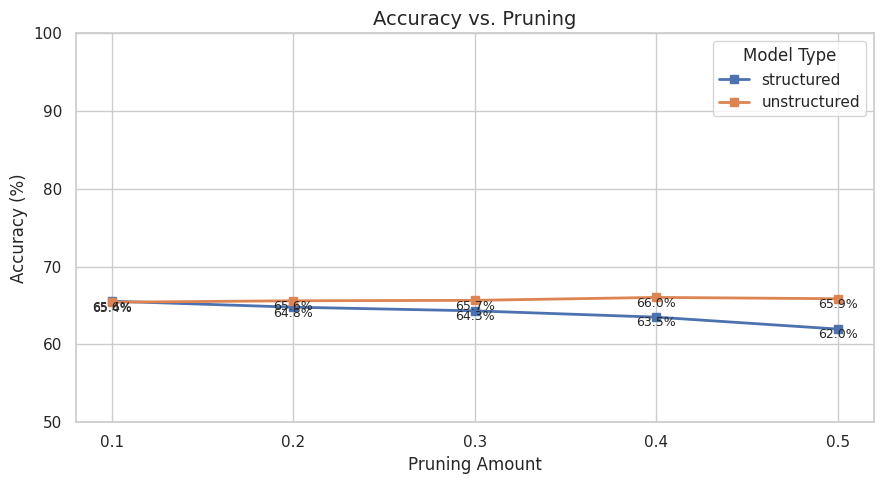

Baseline Accuracy: 66.91278907773753


In [71]:
pruning_amounts = [0.1, 0.2, 0.3, 0.4, 0.5, 0.1, 0.2, 0.3, 0.4, 0.5]
pruning_type = ['structured', 'structured', 'structured', 'structured', 'structured', 'unstructured', 'unstructured', 'unstructured', 'unstructured', 'unstructured']
plot_accuracy_vs_pruning_grouped(pruning_type, pruning_amounts, val_accuracies_st + val_accuracies_unst, test_accuracies_st + test_accuracies_unst)
print(f"Baseline Accuracy: {baseline_accuracy}")

In [30]:
inf_speed_un = []
inf_speed_01 = measure_inference_speed(resnet18_pruned_unst_01, test_loader, quantization=False)
inf_speed_un.append(inf_speed_01)
inf_speed_02 = measure_inference_speed(resnet18_pruned_unst_02, test_loader, quantization=False)
inf_speed_un.append(inf_speed_02)
inf_speed_03 = measure_inference_speed(resnet18_pruned_unst_03, test_loader, quantization=False)
inf_speed_un.append(inf_speed_03)
inf_speed_04 = measure_inference_speed(resnet18_pruned_unst_04, test_loader, quantization=False)
inf_speed_un.append(inf_speed_04)
inf_speed_05 = measure_inference_speed(resnet18_pruned_unst_05, test_loader, quantization=False)
inf_speed_un.append(inf_speed_05)

Avg Inference Time per Batch: 0.1321 sec
Avg Inference Time per Batch: 0.1323 sec
Avg Inference Time per Batch: 0.1235 sec
Avg Inference Time per Batch: 0.1180 sec
Avg Inference Time per Batch: 0.1189 sec


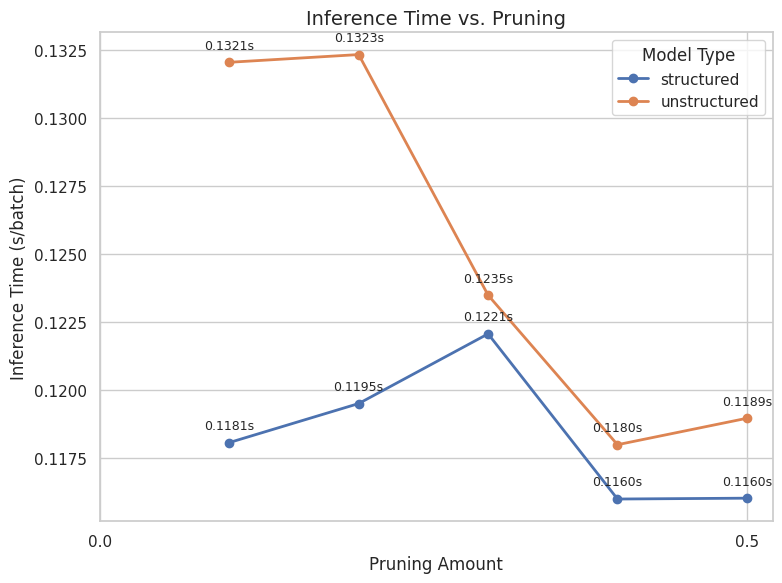

In [41]:
pruning_type = ['structured', 'structured', 'structured', 'structured', 'structured', 'unstructured', 'unstructured', 'unstructured', 'unstructured', 'unstructured']
plot_inference_vs_pruning(pruning_type, pruning_amounts, inf_speed + inf_speed_un)

In [42]:
# Get FLOPs before pruning
flops_before = get_flops(resnet18)

structured_sparsity = compute_sparsity(resnet18_pruned_st_05)
flops_structured_effective = flops_before * (1 - structured_sparsity)

unstructured_sparsity = compute_sparsity(resnet18_pruned_unst_05)
flops_unstructured_effective = flops_before * (1 - unstructured_sparsity)

print(f"FLOPs before pruning: {flops_before:.2f} GFLOPs")
print(f"Structured Pruning: sparsity = {structured_sparsity:.2%}, effective FLOPs = {flops_structured_effective:.2f} GFLOPs")
print(f"Unstructured Pruning: sparsity = {unstructured_sparsity:.2%}, effective FLOPs = {flops_unstructured_effective:.2f} GFLOPs")

FLOPs before pruning: 3.65 GFLOPs
Structured Pruning: sparsity = 37.77%, effective FLOPs = 2.27 GFLOPs
Unstructured Pruning: sparsity = 0.05%, effective FLOPs = 3.65 GFLOPs


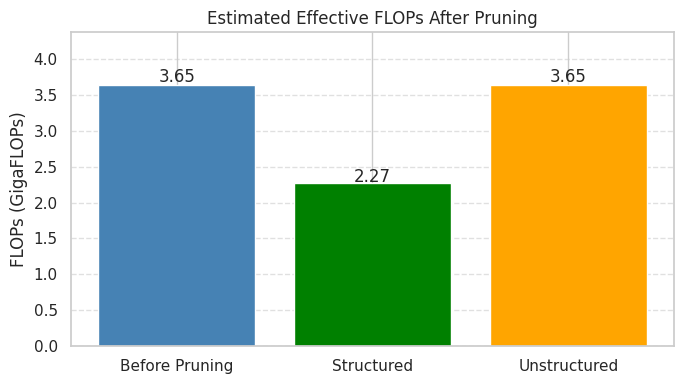

In [43]:
labels = ['Before Pruning', 'Structured', 'Unstructured']
flops_values = [flops_before, flops_structured_effective, flops_unstructured_effective]

plot_flops_after_pruning(labels, flops_values)

#### Quantization

In [20]:
resnet18 = torch.load('resnet18_models/resnet18.pt', weights_only=False)
resnet18_pruned_unst_05 = torch.load('resnet18_pruned_unst/resnet18_pruned_unst_05.pt', weights_only=False)
resnet18_pruned_st_05 = torch.load('resnet18_pruned_st/resnet18_pruned_st_05.pt', weights_only=False)

In [44]:
# === Apply quantization on baseline (no pruning) ===
print("=== Apply quantization on baseline (no pruning) ===")
resnet18_quant = quantize_model(resnet18, train_loader)
evaluate(resnet18_quant, test_loader, quantization=True)
model_size_mb(resnet18_quant)
measure_inference_speed(resnet18_quant, test_loader, quantization=True)

# === Apply quantization on pruned model ===
print("=== Apply quantization on pruned model ===")
resnet18_quant_pr_st = quantize_trained_pruned_model(resnet18_pruned_st_05, train_loader)
evaluate(resnet18_quant_pr_st, test_loader, quantization=True)
model_size_mb(resnet18_quant_pr_st)
measure_inference_speed(resnet18_quant_pr_st, test_loader, quantization=True)

print("=== Apply quantization on pruned model ===")
resnet18_quant_pr_unst = quantize_trained_pruned_model(resnet18_pruned_unst_05, train_loader)
evaluate(resnet18_quant_pr_unst, test_loader, quantization=True)
model_size_mb(resnet18_quant_pr_unst)
measure_inference_speed(resnet18_quant_pr_unst, test_loader, quantization=True)

=== Apply quantization on baseline (no pruning) ===


/home/smahadi/.local/lib/python3.10/site-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


Test Accuracy = 66.68%
Model Size (state_dict): 10.79 MB
Avg Inference Time per Batch: 0.1801 sec
=== Apply quantization on pruned model ===
Test Accuracy = 61.80%
Model Size (state_dict): 10.79 MB
Avg Inference Time per Batch: 0.1678 sec
=== Apply quantization on pruned model ===
Test Accuracy = 65.69%
Model Size (state_dict): 10.79 MB
Avg Inference Time per Batch: 0.1664 sec


0.16637242578827174

In [45]:
torch.save(resnet18_quant, 'resnet18_quantization/resnet18_quant.pt')
torch.save(resnet18_quant_pr_st, 'resnet18_quantization/resnet18_quant_pr_st.pt')
torch.save(resnet18_quant_pr_unst, 'resnet18_quantization/resnet18_quant_pr_unst.pt')

In [46]:
accuracies = []
accuracy_baseline = evaluate(resnet18, test_loader, quantization=True)
accuracy_quant = evaluate(resnet18_quant, test_loader, quantization=True)
accuracy_quant_pr_st = evaluate(resnet18_quant_pr_st, test_loader, quantization=True)
accuracy_quant_pr_unst = evaluate(resnet18_quant_pr_unst, test_loader, quantization=True)
accuracies.append(accuracy_baseline)
accuracies.append(accuracy_quant)
accuracies.append(accuracy_quant_pr_st)
accuracies.append(accuracy_quant_pr_unst)

Test Accuracy = 66.91%
Test Accuracy = 66.68%
Test Accuracy = 61.80%
Test Accuracy = 65.69%


In [47]:
inf_speeds_quantization = []
inf_speed_baseline = measure_inference_speed(resnet18, test_loader, quantization=True)
inf_speed_quant = measure_inference_speed(resnet18_quant, test_loader, quantization=True)
inf_speed_quant_pr_st = measure_inference_speed(resnet18_quant_pr_st, test_loader, quantization=True)
inf_speed_quant_pr_unst = measure_inference_speed(resnet18_quant_pr_unst, test_loader, quantization=True)
inf_speeds_quantization.append(inf_speed_baseline)
inf_speeds_quantization.append(inf_speed_quant)
inf_speeds_quantization.append(inf_speed_quant_pr_st)
inf_speeds_quantization.append(inf_speed_quant_pr_unst)

Avg Inference Time per Batch: 0.6716 sec
Avg Inference Time per Batch: 0.1866 sec
Avg Inference Time per Batch: 0.1842 sec
Avg Inference Time per Batch: 0.1740 sec


#### Plots related to Quantization

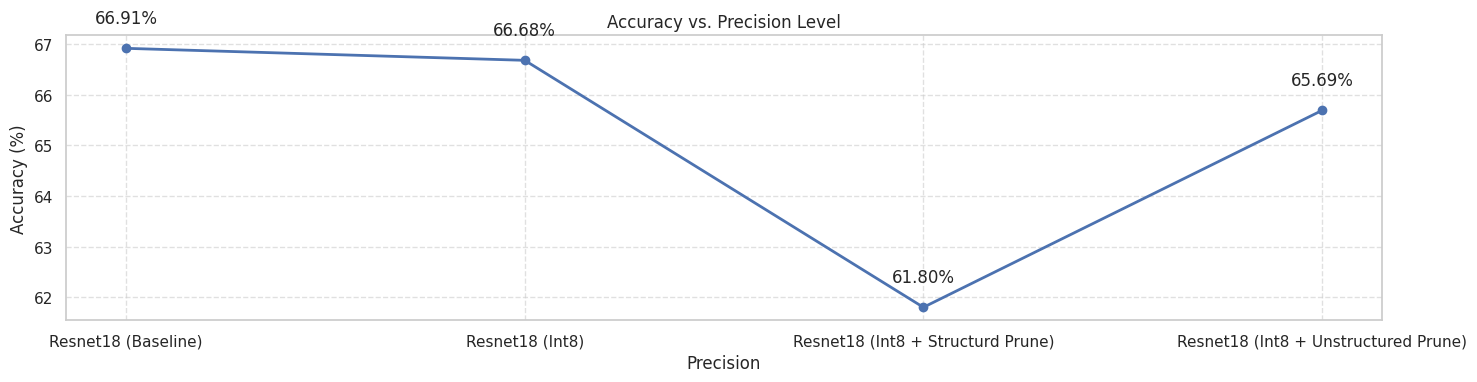

In [48]:
precisions = ['Resnet18 (Baseline)', 'Resnet18 (Int8)', 'Resnet18 (Int8 + Structurd Prune)', 'Resnet18 (Int8 + Unstructured Prune)']
plot_accuracy_vs_precision(precisions, accuracies)

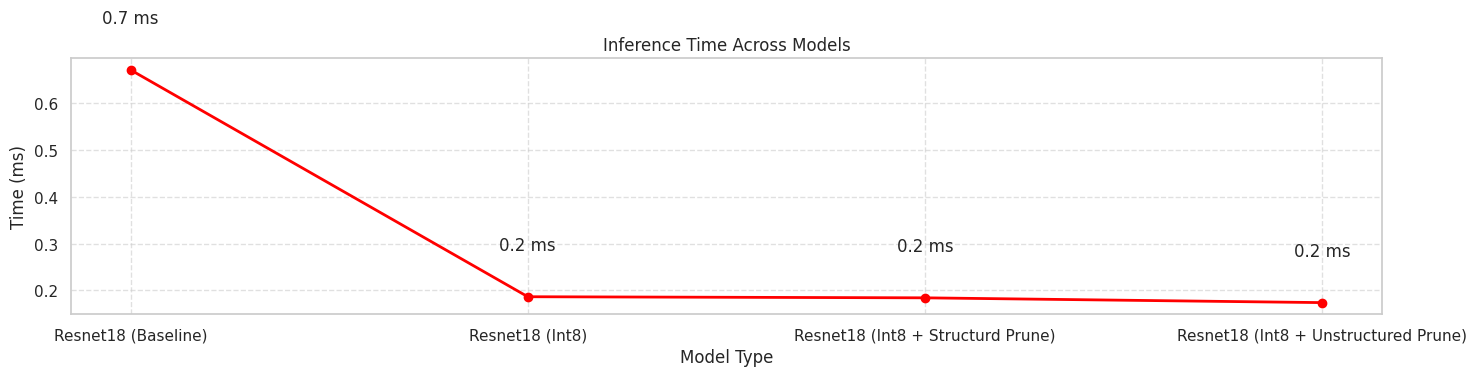

In [49]:
plot_inference_time(precisions, inf_speeds_quantization)

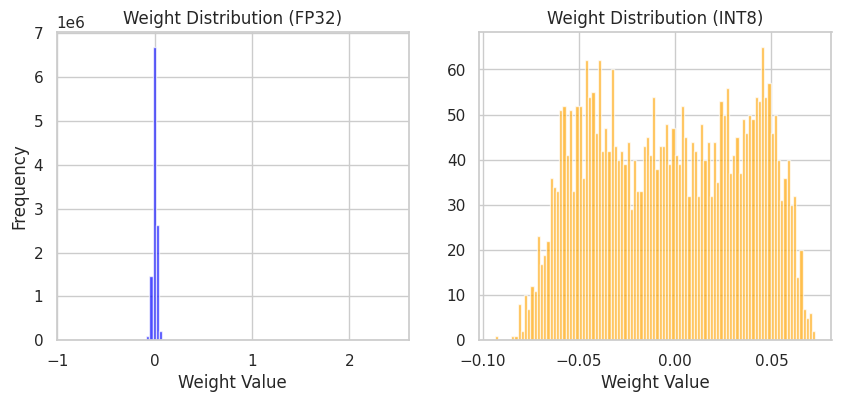

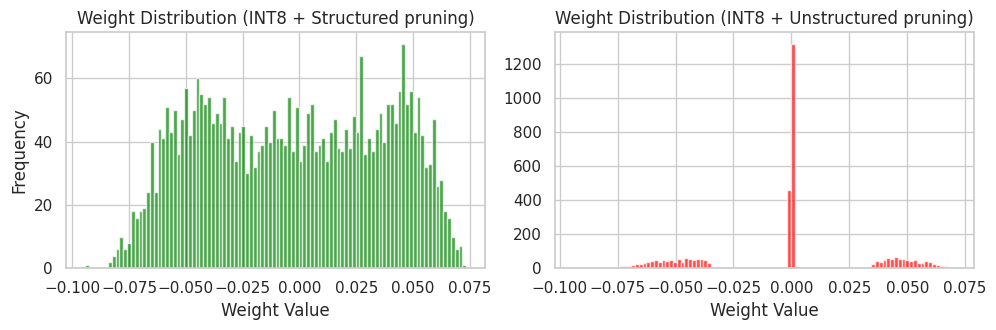

In [50]:
plot_quantized_weight_distribution(resnet18, resnet18_quant, resnet18_quant_pr_st, resnet18_quant_pr_unst)

#### Parameter Count plot

In [65]:
model_labels = []
param_counts = []

# FP32 Baseline
model_labels.append("Baseline")
param_counts.append(get_parameter_count(resnet18))

# Pruned (structured & unstructured)
model_labels += ["Structured-0.5", "Unstructured-0.5"]
param_counts += [
    get_parameter_count(resnet18_pruned_st_05),
    get_parameter_count(resnet18_pruned_unst_05),
]


In [69]:
print("=== Parameter Count ===")
for i, j in zip(model_labels, param_counts):
    print(f"{i}: {j}")

=== Parameter Count ===
Baseline: 11.175296
Structured-0.5: 6.955789
Unstructured-0.5: 11.169512
